In [1]:
import json
from environment import root_dir
from constants import get_result_dir, supported_datasets, supported_llms
import pandas as pd
from utils import load_json
import matplotlib.pyplot as plt
import tiktoken
import seaborn as sns
import argparse
import pdb
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

model_dict = {
    "deepseek-ai/deepseek-reasoner": {
        "label": "DeepSeek-R1",
        "temperature": 0.00,
        "n_samples": 500,
        "color": colors[0],
    },
    "xai/grok-3-mini-beta": {
        "label": "Grok 3 Mini Beta", 
        "temperature": 0.00,
        "n_samples": 500,
        "color": colors[1],
    },
    "openrouter-qwen/qwq-32b": {
        "label": "QwQ-32B",
        "temperature": 0.00,
        "n_samples": 500,
        "color": colors[3],
    },
    "openrouter-microsoft/phi-4-reasoning-plus": {
        "label": "Phi-4-Reasoning-Plus",
        "temperature": 1.00,
        "n_samples": 100,
        "color": colors[2],
    },
    "claude/claude-3-7-sonnet-20250219-thinking": {
        "label": "Claude-3.7-Sonnet",
        "temperature": 0.00,
        "n_samples": 500,
        "color": colors[4],
    },
}

def normalize(text):
    return ' '.join(text.split())

def get_model_text(idx, model_type_json, model_text):
    llm_extracted_json = json.loads(model_text["llm_analysis_extracted_json"].iloc[idx])
    full_reasoning = normalize(model_text["responses"].iloc[idx][0])
    
    for i in range(1, len(llm_extracted_json)):
        model_parsed_txt = normalize(llm_extracted_json[i]["rule_original_text"].split("...")[0])
        try:
            p1, p2 = full_reasoning.split(model_parsed_txt)
            model_type_json[i-1]["text"] = p1
            full_reasoning = model_parsed_txt + p2
        except ValueError:
            model_type_json[i-1]["text"] = ""
        except IndexError:
            print(idx, i, len(llm_extracted_json), len(model_type_json))
            print("Skip this one.")

    return model_type_json

def count_tokens(text):
    try:
        # Using cl100k_base tokenizer (similar to what Qwen uses)
        encoding = tiktoken.get_encoding("cl100k_base")
        return len(encoding.encode(text))
    except:
        # Fallback: approximate token count if tiktoken is not available
        return len(text.split())

def get_df(
    dataset_name,
    model_name,
    response_length,
):
    result_dir = get_result_dir(
        dataset_name = dataset_name,
        model_name = model_name,
        shot = 50,
        template_type = supported_llms[model_name]["template_type"],
        response_length = response_length,
        num_samples = model_dict[model_name]["n_samples"],
        feature_noise = supported_datasets[dataset_name]["feature_noise"],
        label_noise = supported_datasets[dataset_name]["label_noise"],
        data_mode = "default",
        n_query = 10,
        temperature = model_dict[model_name]["temperature"],
    )
    model_funcs = load_json(f"{result_dir}/test_default_gemini_analysis_llm_analysis.json")
    model_text = pd.read_parquet(f"{result_dir}/test_default_gemini_analysis.parquet")

    all_texts, all_accs, all_token_counts, all_cumulative_counts = [], [], [], []
    for i in range(model_funcs["metadata"]["processed_samples"]):
        prompt_idx = model_funcs["samples"][i]["index"]
        models_type_json = model_funcs["samples"][i]["model_evaluation_table"]
        model_type_json = get_model_text(prompt_idx, models_type_json, model_text)
        texts = [model["text"] for model in model_type_json if "text" in model]
        accs = [model["accuracy"] for model in model_type_json if "text" in model]
        token_counts = [count_tokens(text) for text in texts]
        cumulative_token_counts = [sum(token_counts[:j+1]) for j in range(len(token_counts))]
        
        all_texts.extend(texts)
        all_accs.extend(accs)
        all_token_counts.extend(token_counts)
        all_cumulative_counts.extend(cumulative_token_counts)
    
    df = pd.DataFrame({
        "acc": all_accs,
        "token_count": all_cumulative_counts
    })
    return df
    

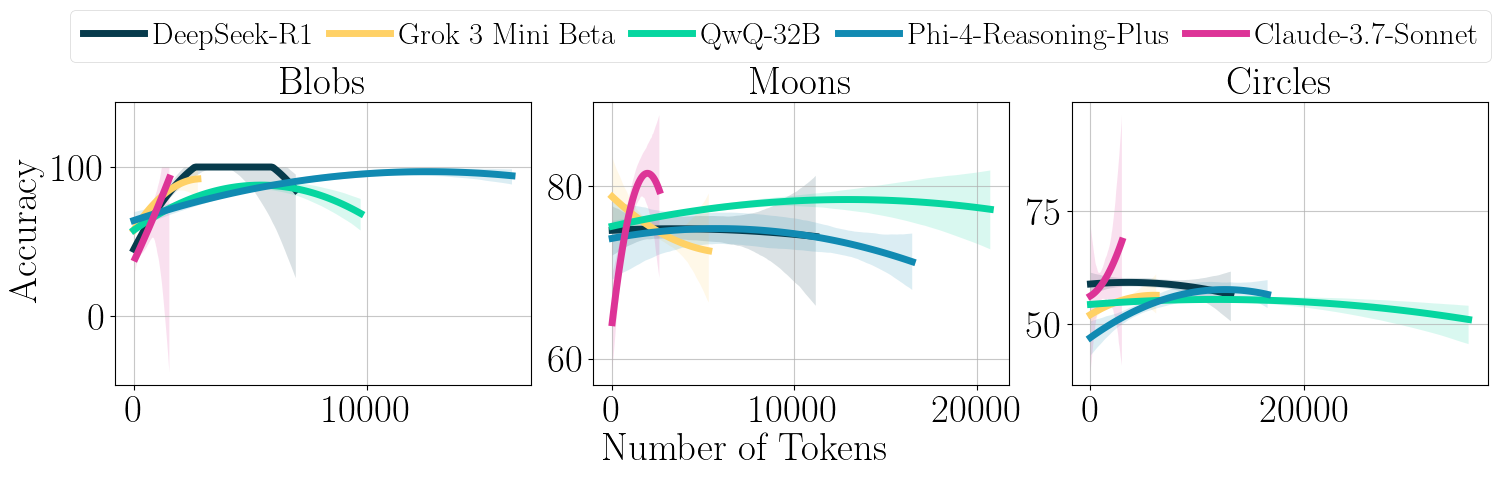

In [3]:
response_length = 3520

fig, axs = plt.subplots(1, 3)  # Reduced width ratio for correlation column
fig.subplots_adjust(left=0.08, bottom=.18, right=0.995, top=.77, wspace=0.15, hspace=0.3)
fig.set_size_inches(15, 4.8) 

for ax_idx, dataset_name in enumerate(["blobs", "moons", "circles"]):
    dfs = []
    labels = []
    model_str = ""
    for model_name in model_dict:
        df = get_df(dataset_name, model_name, response_length)
        dfs.append(df)
        labels.append(model_name)
        model_str += f"{model_name.replace('/', '-')}_"
    for i, (df, label) in enumerate(zip(dfs, labels)):
        # Use regplot but post-process the fitted line to clip at 100
        reg = sns.regplot(
            x="token_count", 
            y="acc", 
            data=df, 
            label=model_dict[label]["label"],
            order=2,
            scatter=False,
            line_kws={'linewidth': 5},
            ax=axs[ax_idx],
            color=colors[i],
        )
        # Clip the fitted line to not exceed 100
        for line in axs[ax_idx].get_lines():
            ydata = line.get_ydata()
            ydata_clipped = [min(y, 100) for y in ydata]
            line.set_ydata(ydata_clipped)
        # Clip the confidence interval (shaded area) to not exceed 100
        for collection in axs[ax_idx].collections:
            # The confidence interval is a PolyCollection
            if hasattr(collection, "get_paths"):
                for path in collection.get_paths():
                    vertices = path.vertices
                    # y values are in the second column
                    vertices[:,1] = [min(y, 100) for y in vertices[:,1]]
        axs[ax_idx].grid(True, linestyle='-', alpha=0.7)
    if ax_idx == 0:
        axs[ax_idx].legend(
            fontsize=22, 
            bbox_to_anchor=(1.6, 1.38), 
            loc='upper center',
            ncol=5,
            handletextpad=0.3,  # reduce space between legend handles and text
            columnspacing=0.5,  # reduce space between columns (handlers)
        )
    axs[ax_idx].set_title(dataset_name.capitalize(), fontsize=28)
    axs[ax_idx].set_xlabel('')
    axs[ax_idx].set_ylabel('')
fig.supxlabel('Number of Tokens', fontsize=28)
fig.supylabel('Accuracy', fontsize=28, x=0.01)
plt.savefig(f'{root_dir}/figures/inductive.pdf')